In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import researchpy as rp
import pandas as pd
import numpy as np

# `4-analysis-note.ipynb`

This notebook takes data/assessments.csv and performs everything done in [`notebooks/1-analysis.ipynb`](../notebooks/1-analysis.ipynb), but instead of using `TOTAL_SCORE` (including to calculate `Acuity`), it uses `CALC_TOTAL_SCORE`. It outputs several .csv files, all of which are available in the [`output/calc_total_score_note folder`](../output/calc_total_score_note).

In [2]:
data_folder = Path('../data/')
output_folder = Path('../output/calc_total_score_note')
output_folder.mkdir(parents=True, exist_ok=True)


fn = Path(data_folder, 'assessments.csv')
df = pd.read_csv(fn)

Instead of using `TOTAL_SCORE` as the basis for acuity groups, use `CALC_TOTAL_SCORE`:

In [3]:
def acuity(row, total_score='TOTAL_SCORE'):
    score = row[total_score]
    assessment = row['AssessmentName']
    if ('Individuals' in assessment and score > 11) or\
       ("Families" in assessment and score > 8) or\
       ('Youth' in assessment and score > 7):
        return '3/High Acuity'
    elif ('Individuals' in assessment and 11 >= score and score > 3) or\
       ("Families" in assessment and 8 >= score and score > 3) or\
       ("Youth" in assessment and 7 >= score and score > 3):
        return '2/Mid Acuity'
    elif ('Individuals' in assessment and score <= 3) or\
       ("Families" in assessment and score <= 3) or\
       ("Youth" in assessment and score <= 3):
        return '1/Low Acuity'
    
df['Acuity'] = df.apply(acuity,total_score='CALC_TOTAL_SCORE',axis=1)

In [4]:
individuals = df[df['AssessmentName'].str.contains('Individuals')].copy()

# Drop any completely empty columns
# e.g. columns that are youth survey-specific and not used for adults
individuals.dropna(axis=1, how='all', inplace=True)

#Convert subscores to an int for math purposes.
for col in [c for c in individuals.columns if c.startswith('CALC_')]:
    individuals[col] = individuals[col].apply(int)

youth = df[df['AssessmentName'].str.contains('Youth')].copy()

# Drop any completely empty columns
# e.g. columns that are adult survey-specific and not used for youth
youth.dropna(axis=1, how='all', inplace=True)

# Convert subscores to an int for math purposes.
for col in [c for c in youth.columns if c.startswith('CALC_')]:
    youth[col] = youth[col].apply(int)

## Analysis: Chi-square tests

**NOTE:** For each year and assessment type, do two chi-square tests: one that compares Black and White people, and another that compares Latino and White people. In addition to individual years, we also perform chi-square tests on data across all years.

In [5]:
chidata = []

years = dict()
for year in df['AssessmentYear'].unique():
    years[year] = [year]
years['Overall'] = df['AssessmentYear'].unique()

for y in years.keys():
    year = years[y]
    for assessment in df['AssessmentName'].unique():
        for group in ['Black', 'Latino']:
            af = df[
                df['AssessmentName'].eq(assessment) & 
                df['AssessmentYear'].isin(year)].copy()
            af['ChiRE'] = df['Race/Ethnicity'].apply(lambda r: r if r in ['White', group] else np.nan)
            af['ChiAcuity'] = df['Acuity'].str.contains('High')
            
            crosstab, test_results, expected = rp.crosstab(af['ChiRE'], af['ChiAcuity'],
                                                       test= "chi-square",
                                                       expected_freqs= True,
                                                       prop= "cell")        
            row = [y, assessment, group]
            row.extend(test_results['results'])
            chidata.append(row)
            
chidf = pd.DataFrame(chidata, columns=['year','assessment','group','pearson chi-square','p-value','cramers phi'])            
chidf['sig'] = chidf['p-value'].lt(0.05)

In [6]:
cf = chidf.sort_values(by=['assessment','group','year']).copy()

fn = Path(output_folder, 'chi-outcomes.csv')
cf.to_csv(fn, index=False)
cf

,year,assessment,group,pearson chi-square,p-value,cramers phi,sig
20,2016,CES for Individuals - CES Survey Part 1,Black,46.9035,0.0000,0.0763,True
0,2017,CES for Individuals - CES Survey Part 1,Black,56.0208,0.0000,0.0680,True
8,2018,CES for Individuals - CES Survey Part 1,Black,144.7830,0.0000,0.0967,True
4,2019,CES for Individuals - CES Survey Part 1,Black,55.5969,0.0000,0.0645,True
16,2020,CES for Individuals - CES Survey Part 1,Black,15.0065,0.0001,0.0369,True
12,2021,CES for Individuals - CES Survey Part 1,Black,45.3943,0.0000,0.0623,True
24,2022,CES for Individuals - CES Survey Part 1,Black,6.3298,0.0119,0.0269,True
28,Overall,CES for Individuals - CES Survey Part 1,Black,374.1620,0.0000,0.0682,True
21,2016,CES for Individuals - CES Survey Part 1,Latino,17.2393,0.0000,0.0570,True
1,2017,CES for Individuals - CES Survey Part 1,Latino,24.3811,0.0000,0.0518,True


## Table: Acuity group distribution by race/ethnicity

In [7]:
acuity_group_folder = Path(output_folder, "acuity_group_distribution")
acuity_group_folder.mkdir(parents=True, exist_ok=True)

acuity_group_distribution_tables = dict()

for assessment in df['AssessmentName'].unique():
    af = df[df['AssessmentName'].eq(assessment)].copy()
    cross_tab_prop = pd.crosstab(af['Race/Ethnicity'], af['Acuity'], normalize='index').mul(100).round(1)
    cross_tab = pd.crosstab(af['Race/Ethnicity'], af['Acuity'])
    
    cross_tab.loc['Overall'] = af.groupby('Acuity').count()['Unique_client_ID']
    
    cross_tab_prop.loc['Overall'] = cross_tab.loc['Overall'].div(cross_tab.loc['Overall'].sum()).mul(100).round(1)
    
    cf = cross_tab.merge(cross_tab_prop, left_index=True, right_index=True,suffixes=(' (count)', " (%)"))
    
    cols = list(cf.columns)
    cols.sort()
    cols.reverse()
    acuity_group_distribution_tables[assessment] = cf[cols].copy()
    
    fn = Path(acuity_group_folder,f'{assessment}.csv')
    acuity_group_distribution_tables[assessment].to_csv(fn)

In [8]:
acuity_group_distribution_tables['CES for Individuals - CES Survey Part 1']#.to_clipboard()

Acuity,3/High Acuity (count),3/High Acuity (%),2/Mid Acuity (count),2/Mid Acuity (%),1/Low Acuity (count),1/Low Acuity (%)
Race/Ethnicity,,,,,,
Asian,468,24.6,1246,65.4,190,10.0
Black,13026,25.7,32300,63.8,5324,10.5
Latino,10533,28.1,24143,64.5,2772,7.4
Other,989,27.6,2309,64.5,283,7.9
Unknown,935,23.5,2688,67.5,359,9.0
White,9578,32.1,18556,62.1,1743,5.8
Overall,35529,27.9,81242,63.7,10671,8.4


In [9]:
acuity_group_distribution_tables['CES for Youth - Next Step Tool']#.to_clipboard()

Acuity,3/High Acuity (count),3/High Acuity (%),2/Mid Acuity (count),2/Mid Acuity (%),1/Low Acuity (count),1/Low Acuity (%)
Race/Ethnicity,,,,,,
Asian,44,36.1,58,47.5,20,16.4
Black,2312,41.3,2509,44.8,781,13.9
Latino,2030,46.1,1859,42.2,511,11.6
Other,266,53.2,185,37.0,49,9.8
Unknown,201,42.2,200,42.0,75,15.8
White,765,55.1,499,35.9,125,9.0
Overall,5618,45.0,5310,42.5,1561,12.5


## Chart: high acuity frequency over time

In [10]:
high_acuity_freq_folder = Path(output_folder, "high_acuity_freq")
high_acuity_freq_folder.mkdir(parents=True, exist_ok=True)

high_acuity_freq_charts = dict()

for assessment in df['AssessmentName'].unique():
    yf = pd.DataFrame()
    for year in df['AssessmentYear'].unique():
        af = df[df['AssessmentName'].eq(assessment) & df['AssessmentYear'].eq(year)].copy()
        cross_tab_prop = pd.crosstab(af['Race/Ethnicity'], af['Acuity'], normalize='index').mul(100).round(1)   
        yf[year] = cross_tab_prop['3/High Acuity'].copy()
    high_acuity_freq_charts[assessment] = yf[range(2016, 2023)]
    
    fn = Path(high_acuity_freq_folder, f'{assessment}.csv')
    high_acuity_freq_charts[assessment].to_csv(fn)

In [11]:
high_acuity_freq_charts['CES for Individuals - CES Survey Part 1']

,2016,2017,2018,2019,2020,2021,2022
Race/Ethnicity,,,,,,,
Asian,14.0,11.2,22.0,26.0,33.5,32.7,29.3
Black,11.9,15.0,21.4,29.1,38.3,32.9,32.3
Latino,13.3,16.3,21.5,30.3,38.0,35.0,32.9
Other,10.5,17.8,26.4,32.3,40.0,30.5,35.2
Unknown,12.6,19.1,22.4,20.2,35.6,29.8,32.7
White,17.5,20.3,30.1,35.3,42.0,39.0,34.9


In [12]:
high_acuity_freq_charts['CES for Youth - Next Step Tool']

,2016,2017,2018,2019,2020,2021,2022
Race/Ethnicity,,,,,,,
Asian,50.0,21.1,30.8,36.0,40.0,35.3,66.7
Black,30.3,23.1,38.8,45.1,51.0,45.5,48.6
Latino,40.2,29.5,40.2,49.1,54.9,56.2,56.0
Other,47.6,33.3,56.7,52.9,57.1,56.5,69.2
Unknown,42.6,34.1,30.4,47.9,47.8,47.7,43.4
White,44.3,41.7,47.4,61.1,60.4,67.1,69.3


## Chart: subscores

In [13]:
subscore_folder = Path(output_folder, "subscore_frequency")
subscore_folder.mkdir(parents=True, exist_ok=True)

subscore_charts = dict()

for assessment in df['AssessmentName'].unique(): 
    af = df[df['AssessmentName'].eq(assessment)].copy()
    af = af.dropna(how='all', axis=1).copy()
    
    subscores = [c for c in af.columns if c.startswith('CALC_') and not c.endswith('_SCORE')]
    subscores.append('GENERAL_SUB_SCORE')
    
    for subscore in subscores:
        af[subscore] = af[subscore].apply(int)
    
    rates = af[
        af['Race/Ethnicity'].isin(['Black','Latino', 'White'])
    ].groupby('Race/Ethnicity')[subscores].mean().T
    
    subscore_charts[assessment] = rates.mul(100).round(1).sort_values(by='Black').copy()
    
    fn = Path(subscore_folder, f'{assessment}.csv')
    subscore_charts[assessment].to_csv(fn)

In [14]:
subscore_charts['CES for Individuals - CES Survey Part 1']

Race/Ethnicity,Black,Latino,White
CALC_WELLNESS_TRIMORBIDITY,17.6,21.7,24.1
GENERAL_SUB_SCORE,19.7,13.9,21.8
CALC_WELLNESS_SUBSTANCE_USE,23.9,34.1,34.4
CALC_RISKS_LEGAL_ISSUES,28.6,35.1,35.3
CALC_WELLNESS_MEDICATIONS,35.1,34.5,40.4
CALC_SOCIALIZATION_SELFCARE,39.9,40.3,44.3
CALC_RISKS_RISK_OF_EXPLOITATION,45.9,46.9,50.9
CALC_WELLNESS_MENTAL_HEALTH,49.3,50.8,56.5
CALC_RISKS_EMERGENCY_SERVICE_USE,56.3,58.1,63.3
CALC_RISKS_RISK_OF_HARM,59.0,60.6,63.5


In [15]:
subscore_charts['CES for Youth - Next Step Tool']

Race/Ethnicity,Black,Latino,White
GENERAL_SUB_SCORE,1.8,3.2,2.3
CALC_WELLNESS_TRIMORBIDITY,9.8,13.3,17.4
CALC_WELLNESS_MEDICATIONS,18.9,21.1,29.7
CALC_WELLNESS_SUBSTANCE_USE,26.7,38.2,39.6
CALC_SOCIALIZATION_SELFCARE,29.1,25.9,27.4
CALC_RISKS_RISK_OF_EXPLOITATION,30.0,32.9,42.4
CALC_WELLNESS_MENTAL_HEALTH,30.3,33.1,45.3
CALC_RISKS_LEGAL_ISSUES,33.8,41.0,37.1
CALC_RISKS_EMERGENCY_SERVICE_USE,35.7,35.7,44.7
CALC_SOCIALIZATION_MEANINGFUL_DAILY_ACTIVITY,38.8,37.2,39.1


## Chart: Acuity score distribution by race

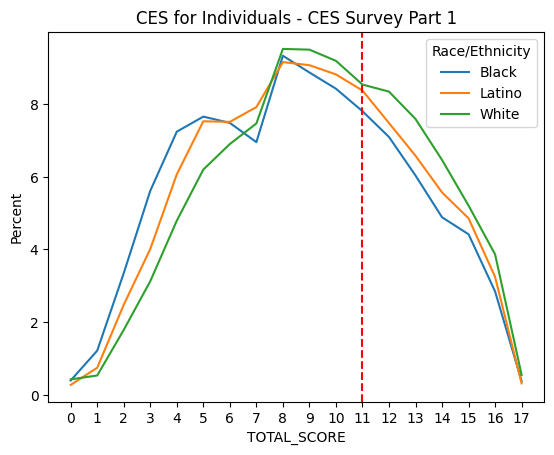

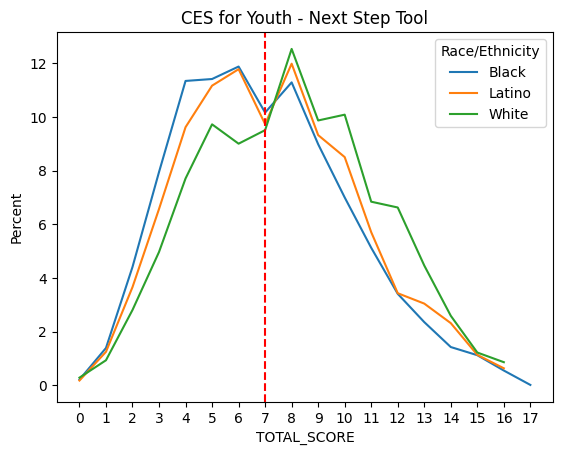

In [16]:
score_dist_folder = Path(output_folder, "score_distribution")
score_dist_folder.mkdir(parents=True, exist_ok=True)

score_dist_charts = dict()

for assessment in df['AssessmentName'].unique(): 
    af = df[df['AssessmentName'].eq(assessment)].copy()
    
    score_dist = af[
        af['Race/Ethnicity'].isin(['Black','White','Latino'])
    ].groupby(['TOTAL_SCORE','Race/Ethnicity'])['Unique_client_ID'].count().unstack().copy()
    
    score_dist_charts[assessment] = score_dist.div(score_dist.sum()).mul(100)
    
    fn = Path(score_dist_folder, f'{assessment}.csv')
    score_dist_charts[assessment].to_csv(fn)
    
    # Plot for context
    score_dist_charts[assessment].plot(title=assessment, ylabel='Percent')
    high_cutoff = af[af['Acuity'].str.contains('High')]['TOTAL_SCORE'].min()
    plt.xticks(np.arange(0, int(af['CALC_TOTAL_SCORE'].max()) + 1, step=1)) 
    plt.axvline(high_cutoff, color='red', linestyle = '--') # theoretical 
pass

## Chart: Rate of people matched, but in yet in, permanent housing by race and score

In [17]:
for i in df['Intervention'].unique():
    df[i] = df['Intervention'].eq(i)

"Matched to Permanent Housing, Not Yet Housed",False,True,Total,pct,pctref
CALC_TOTAL_SCORE,,,,,
0,107.0,NaN,107.0,NaN,NaN
1,1028.0,17.0,1045.0,0.016268,1.6
2,2418.0,48.0,2466.0,0.019465,1.9
3,3813.0,99.0,3912.0,0.025307,2.5
4,5141.0,138.0,5279.0,0.026141,2.6
5,5661.0,200.0,5861.0,0.034124,3.4
6,5457.0,238.0,5695.0,0.041791,4.2
7,5337.0,268.0,5605.0,0.047814,4.8
8,6461.0,409.0,6870.0,0.059534,6.0


"Matched to Permanent Housing, Not Yet Housed",False,True,Total,pct,pctref
CALC_TOTAL_SCORE,,,,,
0,12,1,13,0.076923,7.7
1,103,5,108,0.046296,4.6
2,305,12,317,0.037855,3.8
3,553,23,576,0.039931,4.0
4,780,39,819,0.047619,4.8
5,854,55,909,0.060506,6.1
6,837,50,887,0.056370,5.6
7,701,67,768,0.087240,8.7
8,818,91,909,0.100110,10.0


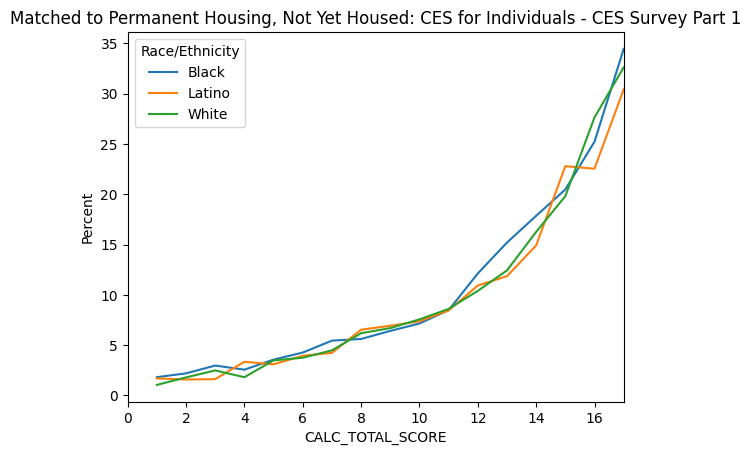

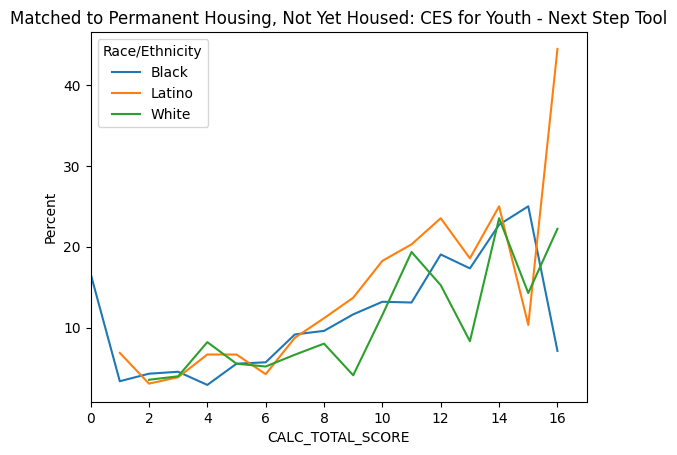

In [18]:
matched_rate_folder = Path(output_folder, "matched_rate")
matched_rate_folder.mkdir(parents=True, exist_ok=True)

perm_charts = dict()
perm_overall_chart = dict()
for assessment in df['AssessmentName'].unique():
    intervention = 'Matched to Permanent Housing, Not Yet Housed'
    filters = df['AssessmentName'].eq(assessment) & \
              df['AssessmentPredatesIntervention']
    re = ['Black', 'White', 'Latino']
    
    permdf = df[filters & df['Race/Ethnicity'].isin(re)].groupby(['CALC_TOTAL_SCORE','Race/Ethnicity',intervention]).count()['Unique_client_ID'].unstack()
    permdf['Total'] = permdf.sum(axis=1)
    permdf['pct'] = permdf[True].div(permdf['Total'])

    perm_charts[assessment] = permdf['pct'].mul(100).copy()

    fn = Path(matched_rate_folder, f'{assessment}.csv')
    perm_charts[assessment].to_csv(fn)
    
    # Overall numbers
    permoveralldf = df[filters].groupby(['CALC_TOTAL_SCORE', intervention]).count()['Unique_client_ID'].unstack()
    permoveralldf['Total'] = permoveralldf.sum(axis=1)
    permoveralldf['pct'] = permoveralldf[True].div(permoveralldf['Total'])
    permoveralldf['pctref'] = permoveralldf['pct'].mul(100).round(1)
    display(permoveralldf)
    
    # Plot for context
    perm_charts[assessment].unstack().plot(xlim=(0,17),title=f'{intervention}: {assessment}', ylabel="Percent")
pass   

## Chart: 2021 Youth Acuity Group Breakdown

In [19]:
af = df[
    df['AssessmentName'].str.contains('Youth') & 
    df['Race/Ethnicity'].isin(['Black','White','Latino']) &
    df['AssessmentYear'].eq(2021)
].copy()

cross_tab_prop = pd.crosstab(af['Race/Ethnicity'], af['Acuity'], normalize='index').mul(100).round(1)

cols = list(cross_tab_prop.columns)
cols.reverse()

display(cross_tab_prop[cols])

cross_tab_prop[cols].to_csv(Path(output_folder, '2021-youth-acuity-breakdown.csv'))

Acuity,3/High Acuity,2/Mid Acuity,1/Low Acuity
Race/Ethnicity,,,
Black,45.5,45.8,8.8
Latino,56.2,36.6,7.3
White,67.1,27.6,5.3
